In [1]:
import numpy as np
import pandas as pd
import json
from dotenv import load_dotenv
import os
import re
import csv
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
from langchain_openai import OpenAIEmbeddings
import openai
from pinecone import Pinecone as PineconeClient, ServerlessSpec
nltk.download('punkt_tab')
from tqdm import tqdm
import unicodedata
load_dotenv()

/home/japhetvance/Documents/data_science/whats_ulam/myenv/lib/python3.12/site-packages/pinecone/data/index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/japhetvance/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
pinecone_api_key = os.environ.get("PINECONE_API_KEY")
pinecone_index_name = os.environ.get("PINECONE_INDEX_NAME")
openai_api_key = os.environ.get("OPENAI_API_KEY")

In [3]:
openai.api_key = openai_api_key
pc = PineconeClient(api_key=pinecone_api_key)

# Pre Processing

In [43]:
# Load the dataset
df = pd.read_csv('data/Dishes.csv')

# Split the multiline dishes and descriptions into lists
dish_list = df['dishes'].str.split('\n\n', expand=False)
description_list = df['Description'].str.split('\n\n', expand=False)

# Initialize lists to hold individual dish names, ingredients, summaries, and descriptions
all_dishes = []
all_ingredients = []
all_summaries = []
all_descriptions = []

# Regex patterns to match ingredients and summary
ingredients_pattern = r'Ingredients: (.+)'
summary_pattern = r'Summary: (.+)'

# Iterate over each row
for i in range(len(dish_list)):
    # Get each dish and corresponding description
    dishes = dish_list[i]
    descriptions = description_list[i]
    
    # Loop through each dish entry
    for j in range(len(dishes)):
        # Extract dish name, ingredients, and summary
        dish_lines = dishes[j].split('\n')
        dish_name = dish_lines[0].strip()  # First line is the dish name
        ingredients = re.search(ingredients_pattern, dishes[j])
        summary = re.search(summary_pattern, dishes[j])
        
        all_dishes.append(dish_name)
        all_ingredients.append(ingredients.group(1) if ingredients else '')
        all_summaries.append(summary.group(1) if summary else '')
        all_descriptions.append(descriptions[j])

# Create a new DataFrame with separate columns for dish name, ingredients, summary, and description
new_df = pd.DataFrame({
    'Dish': all_dishes,
    'Ingredients': all_ingredients,
    'Summary': all_summaries,
    'Description': all_descriptions
})

In [44]:
# Save the new dataset
new_df.to_csv('data/dishes_col.csv', index=False)

print("Data cleaned and saved to 'dishes_col.csv'")

Data cleaned and saved to 'dishes_col.csv'


In [45]:
dishes = pd.read_csv('data/dishes_col.csv')

In [46]:
df.nunique()

dishes         10
Description    10
dtype: int64

## EDA

In [47]:
dishes.describe()

,Dish,Ingredients,Summary,Description
count,50,50,50,50
unique,50,50,50,50
top,6. Sinigang na Bangus (Milkfish in Sour Soup),"Bangus, tomatoes, onions, string beans, eggpla...","Boil water with tomatoes and onions, add tamar...","6. Sinigang na Bangus:\nA tangy, aromatic soup..."
freq,1,1,1,1


In [48]:
dishes.nunique()

Dish           50
Ingredients    50
Summary        50
Description    50
dtype: int64

In [49]:
dishes.head()

,Dish,Ingredients,Summary,Description
0,6. Sinigang na Bangus (Milkfish in Sour Soup),"Bangus, tomatoes, onions, string beans, eggpla...","Boil water with tomatoes and onions, add tamar...","6. Sinigang na Bangus:\nA tangy, aromatic soup..."
1,7. Chicken Afritada,"Chicken, potatoes, carrots, bell peppers, toma...","Sauté garlic and onions, add chicken, vegetabl...","7. Chicken Afritada:\nA vibrant, hearty stew w..."
2,8. Pork Menudo,"Pork, potatoes, carrots, bell peppers, tomato ...","Sauté garlic and onions, add pork and vegetabl...","8. Pork Menudo:\nA rustic, colorful dish with ..."
3,9. Beef Caldereta,"Beef, potatoes, carrots, bell peppers, tomato ...","Sauté garlic and onions, add beef and simmer u...","9. Beef Caldereta:\nA luxurious, deep red stew..."
4,10. Pinakbet,"String beans, eggplant, bitter gourd, squash, ...","Sauté garlic, onions, and tomatoes. Add vegeta...","10. Pinakbet:\nA rustic, colorful vegetable me..."


## Wordcloud

In [50]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np

In [51]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=800,
                      height=400).generate(dishes['Description'].str.cat(sep=' '))

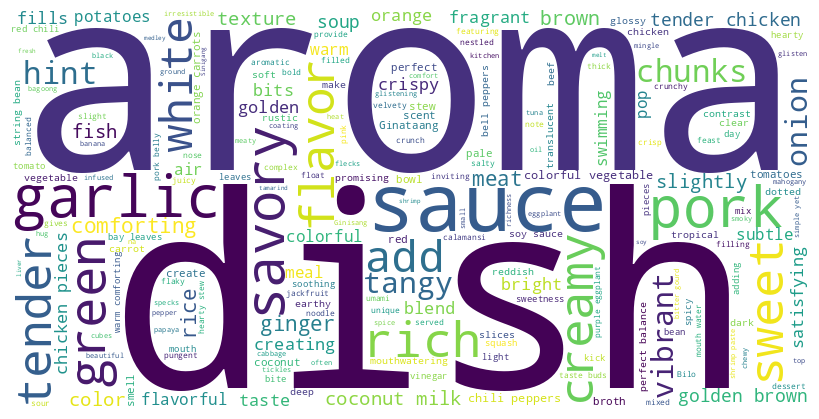

In [52]:
plt.figure(figsize=(8,4),facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Cleaning

In [11]:
# Function to remove newline characters and numbers using re
def preprocess(text):
    if isinstance(text, str):
        # Remove newlines and numbers
        return re.sub(r'[\n\d.]', '', text)  # Replace newlines and numbers with a space
    return text  # Return as is if not a string

def remove_dish_name_from_description(description):
    if isinstance(description, str):
        # Remove the text before the first colon (:) and any space after it
        return re.sub(r'^.*?:\s*', '', description)
    return description  # Return as is if not a string

In [12]:
df_cleaned = dishes.map(preprocess)
df_cleaned['Description'] = df_cleaned['Description'].apply(remove_dish_name_from_description)

In [13]:
df_cleaned.head()

,Dish,Ingredients,Summary,Description
0,Sinigang na Bangus (Milkfish in Sour Soup),"Bangus, tomatoes, onions, string beans, eggpla...","Boil water with tomatoes and onions, add tamar...","A tangy, aromatic soup that's clear and light ..."
1,Chicken Afritada,"Chicken, potatoes, carrots, bell peppers, toma...","Sauté garlic and onions, add chicken, vegetabl...","A vibrant, hearty stew with golden-brown chick..."
2,Pork Menudo,"Pork, potatoes, carrots, bell peppers, tomato ...","Sauté garlic and onions, add pork and vegetabl...","A rustic, colorful dish with cubes of pork swi..."
3,Beef Caldereta,"Beef, potatoes, carrots, bell peppers, tomato ...","Sauté garlic and onions, add beef and simmer u...","A luxurious, deep red stew with chunks of tend..."
4,Pinakbet,"String beans, eggplant, bitter gourd, squash, ...","Sauté garlic, onions, and tomatoes Add vegetab...","A rustic, colorful vegetable medley Green stri..."


## JSON

In [14]:
# Transform the DataFrame into a list of dictionaries
data_for_embedding = df_cleaned.to_dict(orient='records')

# Convert to JSON
import json
json_data = json.dumps(data_for_embedding, indent=4)

In [15]:
# Save to a JSON file
with open('data/dishes_embeddings.json', 'w') as f:
    f.write(json_data)

print("Data saved to 'dishes_embeddings.json'")

Data saved to 'dishes_embeddings.json'


In [16]:
file_path = 'data/dishes_embeddings.json'
with open(file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)
    # Convert values to a list
    dishes = list(data)

    # Print the loaded JSON data (nicely formatted)
    print("Loaded JSON data:")
    print(json.dumps(data, indent=4))

Loaded JSON data:
[
    {
        "Dish": " Sinigang na Bangus (Milkfish in Sour Soup)",
        "Ingredients": "Bangus, tomatoes, onions, string beans, eggplant, tamarind powder, salt",
        "Summary": "Boil water with tomatoes and onions, add tamarind powder, vegetables, and fish Simmer until cooked",
        "Description": "A tangy, aromatic soup that's clear and light The milkfish chunks float in a broth that's a pale, cloudy pink from the tomatoes Green string beans and purple eggplant add pops of color The soup has a sour, mouth-puckering taste from the tamarind, balanced by the mild, flaky fish It smells fresh and slightly acidic, with a hint of fish and vegetables"
    },
    {
        "Dish": " Chicken Afritada",
        "Ingredients": "Chicken, potatoes, carrots, bell peppers, tomato sauce, garlic, onions, cooking oil",
        "Summary": "Saut\u00e9 garlic and onions, add chicken, vegetables, and tomato sauce Simmer until chicken is cooked",
        "Description": "A vibr

# Embeddings

In [4]:
embedding_model = OpenAIEmbeddings(model="text-embedding-ada-002")
embedding_model

OpenAIEmbeddings(client=<openai.resources.embeddings.Embeddings object at 0x78e613dd38c0>, async_client=<openai.resources.embeddings.AsyncEmbeddings object at 0x78e613118a70>, model='text-embedding-ada-002', dimensions=None, deployment='text-embedding-ada-002', openai_api_version='', openai_api_base=None, openai_api_type='', openai_proxy='', embedding_ctx_length=8191, openai_api_key=SecretStr('**********'), openai_organization=None, allowed_special=None, disallowed_special=None, chunk_size=1000, max_retries=2, request_timeout=None, headers=None, tiktoken_enabled=True, tiktoken_model_name=None, show_progress_bar=False, model_kwargs={}, skip_empty=False, default_headers=None, default_query=None, retry_min_seconds=4, retry_max_seconds=20, http_client=None, http_async_client=None, check_embedding_ctx_length=True)

In [5]:
index_name = pinecone_index_name
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=1536,
        metric='cosine',
        spec=ServerlessSpec(
            cloud='aws',
            region='us-east-1'
        )
    )
index = pc.Index(pinecone_index_name)

In [22]:
for i, dish in enumerate(dishes):
    print(f"Dish {i + 1}: {dish['Dish']}")
    print(f"Ingredients: {dish['Ingredients']}")
    print(f"Summary: {dish['Summary']}")
    print(f"Description: {dish['Description']}")
    print()

Dish 1:  Sinigang na Bangus (Milkfish in Sour Soup)
Ingredients: Bangus, tomatoes, onions, string beans, eggplant, tamarind powder, salt
Summary: Boil water with tomatoes and onions, add tamarind powder, vegetables, and fish Simmer until cooked
Description: A tangy, aromatic soup that's clear and light The milkfish chunks float in a broth that's a pale, cloudy pink from the tomatoes Green string beans and purple eggplant add pops of color The soup has a sour, mouth-puckering taste from the tamarind, balanced by the mild, flaky fish It smells fresh and slightly acidic, with a hint of fish and vegetables

Dish 2:  Chicken Afritada
Ingredients: Chicken, potatoes, carrots, bell peppers, tomato sauce, garlic, onions, cooking oil
Summary: Sauté garlic and onions, add chicken, vegetables, and tomato sauce Simmer until chicken is cooked
Description: A vibrant, hearty stew with golden-brown chicken pieces nestled in a rich, red tomato sauce Chunks of white potatoes, orange carrots, and green be

In [23]:
# index.delete(delete_all=True)

In [24]:
def to_ascii(s):
    return unicodedata.normalize('NFKD', s).encode('ascii', 'ignore').decode('ascii')

for item in dishes:
    embedding = openai.embeddings.create(input=item['Description'], model="text-embedding-ada-002").data[0].embedding
    dish_id = to_ascii(item['Dish'])
    index.upsert([(dish_id, embedding, {'Ingredients': item['Ingredients'], 'Summary': item['Summary'], 'Description': item['Description']})])
    print(f"Upserted dish: {dish_id}")

Upserted dish:  Sinigang na Bangus (Milkfish in Sour Soup)
Upserted dish:  Chicken Afritada
Upserted dish:  Pork Menudo
Upserted dish:  Beef Caldereta
Upserted dish:  Pinakbet
Upserted dish:  Chicken Tinola
Upserted dish:  Pork Sinigang
Upserted dish:  Pancit Bihon
Upserted dish:  Chicken Adobo
Upserted dish:  Giniling na Baboy (Ground Pork Stew)
Upserted dish:  Bistek Tagalog
Upserted dish:  Ginataang Hipon (Shrimp in Coconut Milk)
Upserted dish:  Kare-Kare
Upserted dish:  Laing
Upserted dish:  Dinuguan
Upserted dish:  Pork Sisig
Upserted dish:  Bicol Express
Upserted dish:  Chicken Inasal
Upserted dish:  Lechon Kawali
Upserted dish:  Kinilaw na Tuna
Upserted dish:  Arroz Caldo
Upserted dish:  Ginataang Bilo-Bilo
Upserted dish:  Tocino
Upserted dish:  Champorado
Upserted dish:  Ginisang Munggo
Upserted dish:  Chicken Pastel
Upserted dish:  Escabeche
Upserted dish:  Pork Binagoongan
Upserted dish:  Chicken Sopas
Upserted dish:  Ginataang Langka
Upserted dish:  Tortang Giniling
Upserted

# Result

In [6]:
query = "Savory pork in rich blood sauce."

In [7]:
query_embedding = openai.embeddings.create(input=query, model="text-embedding-ada-002").data[0].embedding
results = index.query(vector=query_embedding, top_k=6, include_metadata=True)

In [8]:
results

{'matches': [{'id': ' Dinuguan',
              'metadata': {'Description': 'This unusual dish features tender '
                                          'pork pieces in a deep, dark brown '
                                          'sauce made from pork blood and '
                                          'vinegar Despite its intimidating '
                                          'appearance, it has a rich, savory '
                                          'flavor with a tangy kick The aroma '
                                          'is a mix of garlic, onions, and a '
                                          'slight metallic note from the blood '
                                          "It's often described as a "
                                          '"chocolate meat" dish due to its '
                                          'color, though the flavor is '
                                          'entirely savory',
                           'Ingredients': 'Pork, pork

In [8]:
for match in results['matches']:
    print(f"Dish: {match['id']}, \nScore: {match['score']}, \nSummary: {match['metadata']['Summary']}\n")

Dish:  Dinuguan, 
Score: 0.920092285, 
Summary: Sauté garlic and onions, add pork and cook until brown Pour in vinegar and pork blood Simmer until pork is tender

Dish:  Pork Humba, 
Score: 0.901114941, 
Summary: Marinate pork in soy sauce, vinegar, and spices Simmer until tender and sauce is reduced

Dish:  Pork Menudo, 
Score: 0.891684592, 
Summary: Sauté garlic and onions, add pork and vegetables Pour in tomato sauce and soy sauce, then simmer until meat is tender

Dish:  Giniling na Baboy (Ground Pork Stew), 
Score: 0.887267709, 
Summary: Sauté garlic and onions, add ground pork and vegetables Pour in tomato sauce and soy sauce, then simmer until cooked

Dish:  Pork Estofado, 
Score: 0.881484747, 
Summary: Marinate pork in soy sauce, vinegar, and sugar Simmer with vegetables until tender

Dish:  Pork Sisig, 
Score: 0.880272508, 
Summary: Grill pork belly, chop finely Sauté with chicken liver, onions, and chili peppers Season with calamansi juice, mayonnaise, salt, and pepper



# User Query

In [32]:
def generate_response(query, score_threshold=0.75):
    query_embedding = openai.embeddings.create(input=query, model="text-embedding-ada-002").data[0].embedding
    results = index.query(vector=query_embedding, top_k=10, include_metadata=True)
    filtered_results = [match for match in results['matches'] if match['score'] >= score_threshold]
    return [{
        'Dish': match['id'],
        'Summary': match['metadata']['Summary'],
        'Ingredients': match['metadata']['Ingredients'],
        'Description': match['metadata']['Description'],
        'Score': match['score'],
    } for match in filtered_results]

In [54]:
query = "kyla louisse"
response = generate_response(query)

for item in response:
    print(f"Your Ulam Pare is: {item['Dish']}")
    print(f"Summary: {item['Summary']}")
    print(f"Ingredients: {item['Ingredients']}")
    print(f"Description: {item['Description']}")
    print(f"Score: {item['Score']}")
    print()

In [41]:
if response:
    # Print the first dish's details
    item = response[0]
    print(f"Your ulam pare is: {item['Dish']}")
    print(f"Summary: {item['Summary']}")
    print(f"Ingredients: {item['Ingredients']}")
    print(f"Description: {item['Description']}")
    print(f"Score: {item['Score']}")
    print()

    # List similar dishes
    similar_dishes = [match['Dish'] for match in response[1:]]
    print("Similar Dishes:")
    for i, dish in enumerate(similar_dishes, start=1):
        print(f"{i}. {dish}")

Your ulam pare is:  Chicken Curry
Summary: Sauté garlic and onions Add chicken, vegetables, and curry powder Pour in coconut milk and simmer
Ingredients: Chicken, potatoes, carrots, bell peppers, coconut milk, curry powder, garlic, onions
Description: A colorful, creamy dish with tender chicken pieces swimming in a rich, yellow-orange sauce The sweet smell of coconut milk blends with the earthy aroma of curry spices You'll spot chunks of white potatoes, orange carrots, and bright green and red bell peppers It's warm, comforting, and slightly spicy, best enjoyed over a bed of steaming white rice
Score: 0.920077443

Similar Dishes:
1.  Chicken Afritada
2.  Bicol Express
3.  Tinolang Manok sa Papaya
4.  Ginataang Kalabasa at Sitaw
5.  Escabeche
6.  Chicken Tinola
7.  Laing
8.  Ginataang Kalabasa (Squash in Coconut Milk)
9.  Ginataang Tilapia


In [42]:
# Ask user to select a dish number
choice = int(input("Select a dish number to see more details: ")) - 1
if 0 <= choice < len(similar_dishes):
    selected_dish = response[choice + 1]
    print(f"Dish: {selected_dish['Dish']}")
    print(f"Summary: {selected_dish['Summary']}")
    print(f"Ingredients: {selected_dish['Ingredients']}")
    print(f"Description: {selected_dish['Description']}")
    print(f"Score: {selected_dish['Score']}")
else:
    print("Invalid selection.")

Dish:  Ginataang Tilapia
Summary: Sauté garlic, onions, and ginger Add fish and coconut milk Simmer and add spinach
Ingredients: Tilapia, coconut milk, spinach, garlic, onions, ginger
Description: A creamy white dish featuring tender pieces of tilapia fish in a coconut milk sauce The aroma is a blend of coconut, ginger, and garlic Bright green spinach leaves float in the sauce, adding color and nutrition The fish is soft and flaky, easily breaking apart with a fork The sauce is rich and slightly sweet from the coconut milk, with a hint of spiciness from the ginger It's a comforting, tropical-tasting dish
Score: 0.859001577


In [62]:
def get_embedding(text):
    response = openai.embeddings.create(
        input=text,
        model="text-embedding-ada-002"  # Example of the OpenAI embedding model
    )
    return np.array(response.data[0].embedding) 

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

text1 = "sugar"
text2 = "sweet"

# Get embeddings for "sugar" and "sweet"
embedding_sugar = get_embedding(text1)
embedding_sweet = get_embedding(text2)

# Calculate cosine similarity
similarity = cosine_similarity(embedding_sugar, embedding_sweet)

print(f"Cosine similarity between {text1} and {text2}: {similarity:.4f}")

Cosine similarity between 'sugar' and 'sweet': 0.8432
